# Extraction des données quotidiennes de températures d'ECCC

## Objectifs: 

L'objectif de ce produit est d'extraire les données quotidiennes de températures depuis le jeu de données homogénéisées de seconde génération d'Environnement et Changement Climatique Canada  développé par Vincent and al. 2012

Les données climatiques canadiennes ajustées et homogénéisées (DCCAH) ont été créées pour être utilisées dans les recherches climatiques en incluant les études des changements climatiques. Elles incluent un nombre d’ajustements aux données originales des stations pour traiter les sauts causés par les changements d’instruments et de procédures d’observations. Quelques fois les observations de plusieurs stations ont été combinées pour générer de longues séries temporelles.

Les données quotidiennes homogénéisées des températures maximales, minimales et moyennes and les données quotidiennes ajustées des chutes de pluie, de neige et de précipitation totale sont disponibles au <b>ftp://ccrp.tor.ec.gc.ca/pub/EC_data/AHCCD_daily/</b>.

 

Les observations originales du Service Météorologique de Canada sont disponibles sur http://climate.weather.gc.ca/historical_data/search_historic_data_f.html.


Dans notre étude nous allons filtrer les données pour une province en travaillant avec la liste : Temperature_Stations.xls


In [1]:
# importation des librairies 
import pandas as pd
import os
from datetime import date
import calendar
import numpy as np
import pathlib
import warnings
warnings.filterwarnings("ignore")
from itertools import islice

Nous allons travailler avec les données de température minimales journalières uniquement pour les Territoires du Nord-Ouest du Canada. 
En se référant au document Temperature_Stations.xls, nous voyons que l'acronyme de cette province est : NWT. 

In [2]:
# Définitions des paramètres d'entrée
varin = 'dn'                          # acronyme de la variable                                                                 
path = 'Homog_daily_min_temp_v2018'  # chemin des données                                         
varout = 'Tasmin'                     # variable de sortie
province = 'NWT'                      # province à extraire 

On va crée un dataframe avec la liste des stations d'ECCC. 

In [3]:
dataframe = pd.read_excel("./Temperature_Stations.xls", skiprows = range(0, 3))
dataframe.head()

Prov Nom de station    stnid  année déb.  mois déb.  année fin.  mois fin.  \
0   BC        AGASSIZ  1100120        1893          1        2018          9   
1   BC          ATLIN  1200560        1905          8        2018         12   
2   BC    BARKERVILLE  1090660        1888          2        2015          3   
3   BC     BEAVERDELL  1130771        1939          1        2006          9   
4   BC    BELLA COOLA  1060841        1895          5        2017         11   

   lat (deg)  long (deg)  élév (m) stns jointes  
0      49.25     -121.77        15            N  
1      59.57     -133.70       674            N  
2      53.07     -121.52      1265            N  
3      49.48     -119.05       838            Y  
4      52.37     -126.68        18            Y

On va filtrer les données sur notre province d'étude et créer une variable globale.

In [4]:
globals()['dataframe_'+province] = dataframe.loc[(dataframe["Prov"] == province),:]
globals()['dataframe_'+province].count()

Prov              13
Nom de station    13
stnid             13
année déb.        13
mois déb.         13
année fin.        13
mois fin.         13
lat (deg)         13
long (deg)        13
élév (m)          13
stns jointes      13
dtype: int64

On trouve 13 stations pour cette province. Pour obtenir de l'information sur nos stations:

In [5]:
globals()['dataframe_'+province].iloc[0]

Prov                     NWT
Nom de station    CAPE PARRY
stnid                2200675
année déb.              1957
mois déb.                  5
année fin.              2018
mois fin.                 12
lat (deg)              70.17
long (deg)           -124.72
élév (m)                  87
stns jointes               N
Name: 65, dtype: object

Nous voulons par exemple travailler avec la station CAPE PARRY: stnid = 2200675. 
On va extraire ici les données au format ascii de la station.

In [6]:
stnid = '2200675'   
f1 = open('./'+path+'/'+str(varin)+str(stnid)+'.txt', 'r')
for line in islice(f1, 10):
        print(line)

2200675,    CAPE PARRY     ,  NWT, station not joined, Homogenized daily minimum temperature        , Deg Celcius,          Updated to December 2018

2200675,    CAPE PARRY     ,  NWT, station non jointe, Temperature quotidienne minimale homogeneisee, Deg Celcius, Mise a jour jusqu a decembre 2018

 Year Mo  Day 01  Day 02  Day 03  Day 04  Day 05  Day 06  Day 07  Day 08  Day 09  Day 10  Day 11  Day 12  Day 13  Day 14  Day 15  Day 16  Day 17  Day 18  Day 19  Day 20  Day 21  Day 22  Day 23  Day 24  Day 25  Day 26  Day 27  Day 28  Day 29  Day 30  Day 31

Annee Mo Jour 01 Jour 02 Jour 03 Jour 04 Jour 05 Jour 06 Jour 07 Jour 08 Jour 09 Jour 10 Jour 11 Jour 12 Jour 13 Jour 14 Jour 15 Jour 16 Jour 17 Jour 18 Jour 19 Jour 20 Jour 21 Jour 22 Jour 23 Jour 24 Jour 25 Jour 26 Jour 27 Jour 28 Jour 29 Jour 30 Jour 31

 1957  5   -16.7   -19.4   -18.9   -14.4   -10.6   -11.7   -13.9    -5.0   -11.7   -16.1   -16.7   -15.0   -13.9   -20.0   -19.4   -18.3   -16.7   -11.1    -0.6    -1.1    -5.6    -8.9

### Nettoyage des données: 

On voit que dans notre jeu de données nous avons pour chaque ligne les données quotidiennes par année et par mois suivant la structure  :

<p style="color:blue;font-size:12px;"> Annee Mo Jour 01 Jour 02 Jour 03 Jour 04 Jour 05 Jour 06 Jour 07 Jour 08 Jour 09 Jour 10 Jour 11 Jour 12 Jour 13 Jour 14 Jour 15 Jour 16 Jour 17 Jour 18 Jour 19 Jour 20 Jour 21 Jour 22 Jour 23 Jour 24 Jour 25 Jour 26 Jour 27 Jour 28 Jour 29 Jour 30 Jour 31 </p>  

Nos fichiers ont un en-tête de 4 lignes que nous devrons supprimer.
On va également supprimer les caractères alphanumériques, nettoyer les valeurs manquantes et créer un dataframe.

In [7]:
f1 = open('./'+path+'/'+str(varin)+str(stnid)+'.txt', 'r')
f2 = open('./tmp.txt', 'w')
for line in f1:
    for word in line:
            if word == 'M':
                f2.write(word.replace('M', ' '))
            elif word == 'a':
                f2.write(word.replace('a', ' '))                    
            else:
                f2.write(word)
f1.close()
f2.close()      
df_station = pd.read_csv('./tmp.txt', delim_whitespace=True, skiprows = range(0, 4))
df_station.head()

1957   5  -16.7  -19.4  -18.9  -14.4  -10.6 -11.7 -13.9  -5.0   ...     \
0  1957   6   -6.1   -6.7   -6.1   -2.2   -3.3  -2.8  -3.3  -3.9   ...      
1  1957   7    2.2    1.7    0.0    0.0    5.6   7.2   5.6   2.2   ...      
2  1957   8    1.1    1.7    1.7    1.7    1.1   2.2   1.1   0.6   ...      
3  1957   9    2.8    1.1    0.6    3.3   10.6   8.3   4.4   2.8   ...      
4  1957  10  -10.0  -11.1  -10.6  -10.0  -11.1  -3.3  -2.8  -3.3   ...      

    -8.9  -6.7  -7.8  -6.1  -7.2 -5.6.1 -6.1.1 -7.2.1 -6.1.2     -8.3  
0   -3.9   0.0  -2.2   2.2  -2.2    1.7    1.1    1.1    1.7  -9999.9  
1    0.0  -1.1  -1.1   1.1   0.0    2.2    1.1    2.8   -0.6      1.7  
2    2.8   0.0   1.7   6.7   2.8    3.3    7.2    5.0    0.0      1.7  
3   -3.9  -5.6  -6.7  -7.8  -8.3   -7.2   -4.4   -7.8   -5.6  -9999.9  
4  -12.8  -7.2  -7.2  -8.9  -8.9  -16.1  -16.7  -13.3   -9.4    -16.7  

[5 rows x 33 columns]

In [8]:
df_station.columns = ['Annee', 'Mois', 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10',
                                  'D11','D12','D13','D14','D15','D16','D17','D18','D19','D20',
                                  'D21','D22','D23','D24','D25','D26','D27','D28','D29','D30','D31']
     
os.remove("./tmp.txt")
   
   # nettoyage des valeurs manquantes 
try:  
    df_station = df_station.replace({'E':''}, regex=True)
except:
       pass
try: 
    df_station = df_station.replace({'a':''}, regex=True)
except:
       pass
try:     
    df_station = df_station.replace({'-9999.9':''}, regex=True)
except:
       pass
try:     
    df_station = df_station.replace({-9999.9:''}, regex=True)
except:
       pass    
    
for col in  df_station.columns[2:]:
       df_station[col] = pd.to_numeric(df_station[col], errors='coerce')      

In [9]:
df_station.head()

Annee  Mois    D1    D2    D3    D4    D5   D6   D7   D8  ...    D22  D23  \
0   1957     6  -6.1  -6.7  -6.1  -2.2  -3.3 -2.8 -3.3 -3.9  ...   -3.9  0.0   
1   1957     7   2.2   1.7   0.0   0.0   5.6  7.2  5.6  2.2  ...    0.0 -1.1   
2   1957     8   1.1   1.7   1.7   1.7   1.1  2.2  1.1  0.6  ...    2.8  0.0   
3   1957     9   2.8   1.1   0.6   3.3  10.6  8.3  4.4  2.8  ...   -3.9 -5.6   
4   1957    10 -10.0 -11.1 -10.6 -10.0 -11.1 -3.3 -2.8 -3.3  ...  -12.8 -7.2   

   D24  D25  D26   D27   D28   D29  D30   D31  
0 -2.2  2.2 -2.2   1.7   1.1   1.1  1.7   NaN  
1 -1.1  1.1  0.0   2.2   1.1   2.8 -0.6   1.7  
2  1.7  6.7  2.8   3.3   7.2   5.0  0.0   1.7  
3 -6.7 -7.8 -8.3  -7.2  -4.4  -7.8 -5.6   NaN  
4 -7.2 -8.9 -8.9 -16.1 -16.7 -13.3 -9.4 -16.7  

[5 rows x 33 columns]

On peut maintenant détecter les années minimales et maximales d'enregistrement et écrire les données quotidienne sur une seule colonne. 

In [10]:
yearmin = df_station['Annee'].min()                                   # année de début d'enregistrement pour cette station
yearmax = df_station['Annee'].max()                                   # année de fin
m_start =  df_station['Mois'].loc[(df_station['Annee'] == yearmin)].min()# premier mois 
m_end   =  df_station['Mois'].loc[(df_station['Annee'] == yearmax)].max()# dernier mois
d_end = calendar.monthrange(yearmax, m_end)[1]                     # nombre de jours d'enregistrement 

####################################Extraction des données quotidiennes  et ajout d'une colonne Date   
tmp_tmin = [ ] 
for year in range(yearmin,yearmax+1):    ### Boucle sur les annees
    for month in range(1,13):
        df = []
        last_day = calendar.monthrange(year, month)[1] 
        tmin = df_station.loc[(df_station["Annee"] == year) & (df_station["Mois"] == month)].iloc[:,2:last_day+2].values
           
        if len(tmin) == 0:
            a = np.empty((calendar.monthrange(year,month)[1]))
            a[:] = np.nan
            df=pd.DataFrame(a)
        else:
            df=pd.DataFrame(tmin.T)
               
        start = date(year, month, 1)
        end =   date(year, month, last_day)
        delta=(end-start) 
        nb_days = delta.days + 1 
        rng = pd.date_range(start, periods=nb_days, freq='D')          
        df['datetime'] = rng
        df.index = df['datetime']
        tmp_tmin.append(df)
           
tmp_tmin = pd.concat(tmp_tmin) 
df = pd.DataFrame({'datetime': tmp_tmin['datetime'], 'Var': tmp_tmin.iloc[:,0]}, columns = ['datetime','Tmin']) 
df.index = df['datetime']
tmp_tmin = tmp_tmin.drop(["datetime"], axis=1)
tmp_tmin.head()

0
datetime      
1957-01-01 NaN
1957-01-02 NaN
1957-01-03 NaN
1957-01-04 NaN
1957-01-05 NaN

Visualisation rapide des moyennes mensuelles de la température pour le mois de janvier. 
On va grouper les données par mois et calculer la moyenne. 

In [11]:
import matplotlib.pylab as plt
import datetime
month_tmin = tmp_tmin.resample('M').mean()
month_tmin.head()

0
datetime      
1957-01-31 NaN
1957-02-28 NaN
1957-03-31 NaN
1957-04-30 NaN
1957-05-31 NaN

In [12]:
tmin_janvier = month_tmin[month_tmin.index.month==1]
tmin_janvier.head()

0
datetime             
1957-01-31        NaN
1958-01-31 -27.496774
1959-01-31 -31.664516
1960-01-31 -35.148387
1961-01-31 -31.354839

In [13]:
yearmin

1957

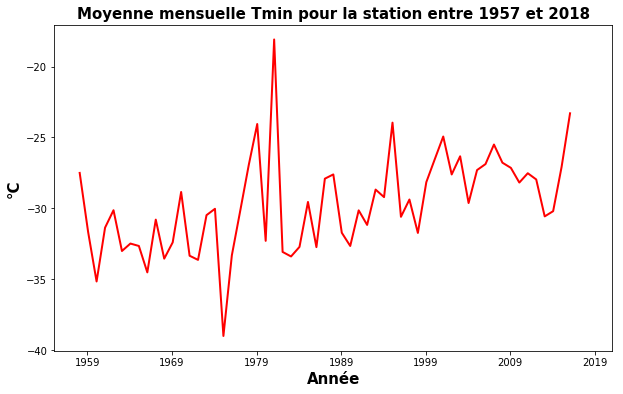

In [14]:
plt.rcParams["figure.figsize"]=[10,6]        
plt.plot(tmin_janvier.index, tmin_janvier[:],  label='Tmin Station', linewidth=2, c='r')
plt.title('Moyenne mensuelle Tmin pour la station entre ' + datetime.date(yearmin, 1, 1).strftime('%Y')+ ' et '  + datetime.date(yearmax, 1, 1).strftime('%Y'), fontsize=15, color='black', weight='semibold')
plt.xlabel('Année', fontsize=15, color='black', weight='semibold')
plt.ylabel('°C', fontsize=15, color='black', weight='semibold')
plt.show()

## Code final

Le code qui suit permet d'extraire toutes les stations pour une province spécifique mais pour une période commune.
Nous souhaitons par exemple extraire toutes les données quotidiennes de température pour la province des Territoires du Nord-Ouest mais uniquement pour la période commune: 1989-2018. 
Nous souhaitons avoir un fichier par station. 

In [15]:
import pandas as pd
import os
from datetime import date
import calendar
import numpy as np
import pathlib

##########################-- Partie du code à modifier --######################                                                            #
varin = 'dn'                                                                  
path = 'Homog_daily_min_temp_v2018'                                           
varout = 'Tasmoy'
province = 'NWT'  
yearmin = 1989 
yearmax = 2018
###############################################################################

### lecture de toutes les stations d'ECCC pour la température
dataframe = pd.read_excel("./Temperature_Stations.xls", skiprows = range(0, 3))

### on va filtrer les données ayant pour période commune: yearmin - yearmax
globals()['dataframe_'+province] = dataframe.loc[(dataframe["Prov"] == province) & (dataframe["année déb."] <= yearmin) & (dataframe["année fin."] >= yearmax),:]

## boucle sur chaque station et extraction des séries quotidiennes
names = []
for i, row in globals()['dataframe_'+province].iterrows():
   stnid = row['stnid']   
   f1 = open('./'+path+'/'+str(varin)+str(stnid)+'.txt', 'r')
   f2 = open('./tmp.txt', 'w')

### nettoyage des données   
   for line in f1:
        for word in line:
            if word == 'M':
                f2.write(word.replace('M', ' '))
            elif word == 'a':
                f2.write(word.replace('a', ' '))                    
            else:
                f2.write(word)
   f1.close()
   f2.close()
          
   station = pd.read_csv('./tmp.txt', delim_whitespace=True, skiprows = range(0, 4))
   
   station.columns = ['Annee', 'Mois', 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10',
                                  'D11','D12','D13','D14','D15','D16','D17','D18','D19','D20',
                                  'D21','D22','D23','D24','D25','D26','D27','D28','D29','D30','D31']
     
   os.remove("./tmp.txt")
   
   # nettoyage des valeurs manquantes 
   try:  
       station = station.replace({'E':''}, regex=True)
   except:
       pass
   try: 
       station = station.replace({'a':''}, regex=True)
   except:
       pass
   try:     
       station = station.replace({'-9999.9':''}, regex=True)
   except:
       pass
   try:     
       station = station.replace({-9999.9:''}, regex=True)
   except:
       pass    
       
   for col in  station.columns[2:]:
       station[col] = pd.to_numeric(station[col], errors='coerce')
        
   m_start =  station['Mois'].loc[(station['Annee'] == yearmin)].min()
   m_end   =  station['Mois'].loc[(station['Annee'] == yearmax)].max()
   
   d_end = calendar.monthrange(yearmax, m_end)[1]
   
####################################Extraction des données quotidiennes  et ajout d'une colonne Date   
   tmp_tmin = [ ] 
   for year in range(yearmin,yearmax+1):    ### Boucle sur les annees
       for month in range(1,13):
           df = []
           last_day = calendar.monthrange(year, month)[1] 
           tmin = station.loc[(station["Annee"] == year) & (station["Mois"] == month)].iloc[:,2:last_day+2].values
           
           if len(tmin) == 0:
               a = np.empty((calendar.monthrange(year,month)[1]))
               a[:] = np.nan
               df=pd.DataFrame(a)
           else:
               df=pd.DataFrame(tmin.T)
               
           start = date(year, month, 1)
           end =   date(year, month, last_day)
           delta=(end-start) 
           nb_days = delta.days + 1 
           rng = pd.date_range(start, periods=nb_days, freq='D')          
           df['datetime'] = rng
           df.index = df['datetime']
           tmp_tmin.append(df)
           
   tmp_tmin = pd.concat(tmp_tmin) 
   df = pd.DataFrame({'datetime': tmp_tmin['datetime'], 'Var': tmp_tmin.iloc[:,0]}, columns = ['datetime','Tmin']) 
   df.index = df['datetime']
   tmp_tmin = tmp_tmin.drop(["datetime"], axis=1)
      
   name = row['Nom de station'].replace(' ','_')
   name = name.replace("'",'')
   names.append(name)
   mypath='./Daily_data_by_Province/'+varout+'/'
   pathlib.Path(mypath).mkdir(parents=True, exist_ok=True)
   
   tmp_tmin.to_csv(mypath+name+'_daily_'+varout+'_'+str(yearmin)+'-'+str(yearmax)+'.csv')
   
### ecriture d'un fichier latlon des stations traitées entre yearmin et yearmax         
latlon = pd.DataFrame({'Latitude': globals()['dataframe_'+province]["lat (deg)"], 'Longitude': globals()['dataframe_'+province]["long (deg)"] }, columns = ['Latitude','Longitude']) 
latlon.to_csv('./Daily_data_by_Province/stations_latlon_'+province+'.csv')
names = pd.DataFrame(names)
names.to_csv('./Daily_data_by_Province/stations_noms_'+province+'.csv')

base_filename = './Daily_data_by_Province/stations_noms_'+province+'.txt'
names[0].to_csv(base_filename, sep='\t', index = False) 